In [56]:
import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Config

In [2]:
target_gauge_id = 3465
predict_next_hours = 24

### Data Loading

In [59]:
data = pd.read_csv(f"../dataset/processed/simple/{target_gauge_id}/{predict_next_hours}.gz")
data.dropna(how="any", inplace=True)

In [60]:
x_data = data.loc[:, (data.columns != "DATE") & (data.columns != "TARGET")]
y_data = data["TARGET"]

In [61]:
x_data

,DISTANCE_0,DISTANCE_1,DISTANCE_2,DISTANCE_3,DISTANCE_4,DISTANCE_5,DISTANCE_6,DISTANCE_7,DISTANCE_8,DISTANCE_9,...,LEVEL_9_62,LEVEL_9_63,LEVEL_9_64,LEVEL_9_65,LEVEL_9_66,LEVEL_9_67,LEVEL_9_68,LEVEL_9_69,LEVEL_9_70,LEVEL_9_71
0,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,78.500000,78.333333,80.166667,81.666667,81.666667,82.500000,84.166667,79.000000,71.166667,69.166667
1,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,78.333333,80.166667,81.666667,81.666667,82.500000,84.166667,79.000000,71.166667,69.166667,68.333333
2,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,80.166667,81.666667,81.666667,82.500000,84.166667,79.000000,71.166667,69.166667,68.333333,62.166667
3,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,81.666667,81.666667,82.500000,84.166667,79.000000,71.166667,69.166667,68.333333,62.166667,59.500000
4,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,81.666667,82.500000,84.166667,79.000000,71.166667,69.166667,68.333333,62.166667,59.500000,59.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,89.333333,88.000000,87.000000,83.666667,79.833333,79.333333,79.000000,79.000000,80.833333,84.166667
11564,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,88.000000,87.000000,83.666667,79.833333,79.333333,79.000000,79.000000,80.833333,84.166667,86.000000
11565,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,87.000000,83.666667,79.833333,79.333333,79.000000,79.000000,80.833333,84.166667,86.000000,86.000000
11566,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,83.666667,79.833333,79.333333,79.000000,79.000000,80.833333,84.166667,86.000000,86.000000,81.833333


In [62]:
y_data

0        150.000000
1        143.833333
2        137.000000
3        131.666667
4        127.666667
            ...    
11563    138.666667
11564    139.166667
11565    140.166667
11566    141.000000
11567    141.166667
Name: TARGET, Length: 11067, dtype: float64

### Data Processing

In [7]:
# Split datasets into train and test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

# Normalize datasets with scaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [66]:
# Select PyTorch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

### Model Setup

In [67]:
# Instantiate the model
model = nn.Sequential(
    nn.Linear(x_train_tensor.shape[1], x_train_tensor.shape[1] * 2),
    nn.ReLU(),
    nn.Linear(x_train_tensor.shape[1] * 2, x_train_tensor.shape[1]),
    nn.ReLU(),
    nn.Linear(x_train_tensor.shape[1], x_train_tensor.shape[1] // 4),
    nn.ReLU(),
    nn.Linear(x_train_tensor.shape[1] // 4, 1),
    nn.Softplus(),
).to(device)

In [10]:
# Training parameters
number_epochs = 500
learning_rate = 0.0001
batch_size = 256
batch_start = torch.arange(0, len(x_train), batch_size)

In [11]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Model Training

In [12]:
# Hold the best model
best_mse = np.inf
best_weights = None
history = []

# Training loop
for epoch in range(number_epochs):
    model.train()

    with tqdm.tqdm(batch_start, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")

        for start in bar:
            # Take a batch
            x_batch = x_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]

            # Forward pass
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
 
            # Update weights
            optimizer.step()

            # Print progress
            bar.set_postfix(mse=float(loss))

    # Evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(x_test_tensor)
    mse = criterion(y_pred, y_test_tensor)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# Restore model and return best accuracy
model.load_state_dict(best_weights)

Epoch 199: 100%|██████████| 31/31 [00:01<00:00, 16.46batch/s, mse=4.26]


<All keys matched successfully>

MSE: 58.56
RMSE: 7.65


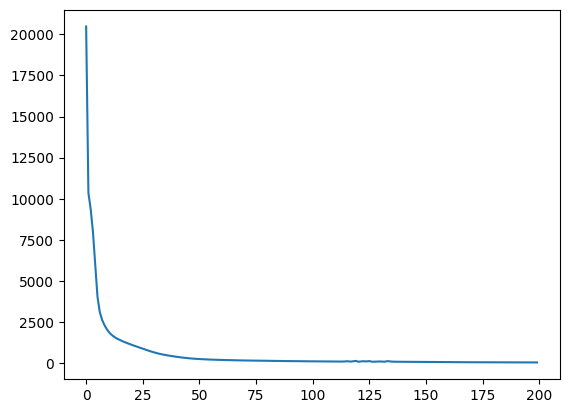

In [13]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

### Model Explaining

In [21]:
model.eval()

Sequential(
  (0): Linear(in_features=730, out_features=1460, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1460, out_features=730, bias=True)
  (3): ReLU()
  (4): Linear(in_features=730, out_features=182, bias=True)
  (5): ReLU()
  (6): Linear(in_features=182, out_features=1, bias=True)
  (7): Softplus(beta=1.0, threshold=20.0)
)

In [14]:
x_samples_main = x_train_tensor[torch.randint(len(x_train_tensor), (1000,))]
x_samples_values = x_train_tensor[torch.randint(len(x_train_tensor), (500,))]

In [15]:
explainer = shap.DeepExplainer(model, x_samples_main)
shap_values = explainer.shap_values(x_samples_values)
shap_values = np.squeeze(shap_values)

In [16]:
shap_df = pd.DataFrame({
    "mean_abs_shap": np.mean(np.abs(shap_values), axis=0), 
    "stdev_abs_shap": np.std(np.abs(shap_values), axis=0), 
    "name": data.columns[2:],
})
shap_df.sort_values("mean_abs_shap", ascending=False)

,mean_abs_shap,stdev_abs_shap,name
585,5.871466,6.082347,LEVEL_7_71
81,4.557693,3.534410,LEVEL_0_71
153,4.464369,4.515762,LEVEL_1_71
298,4.390991,3.940700,LEVEL_4_0
225,3.852451,4.509013,LEVEL_2_71
...,...,...,...
6,0.000000,0.000000,DISTANCE_6
7,0.000000,0.000000,DISTANCE_7
8,0.000000,0.000000,DISTANCE_8
9,0.000000,0.000000,DISTANCE_9


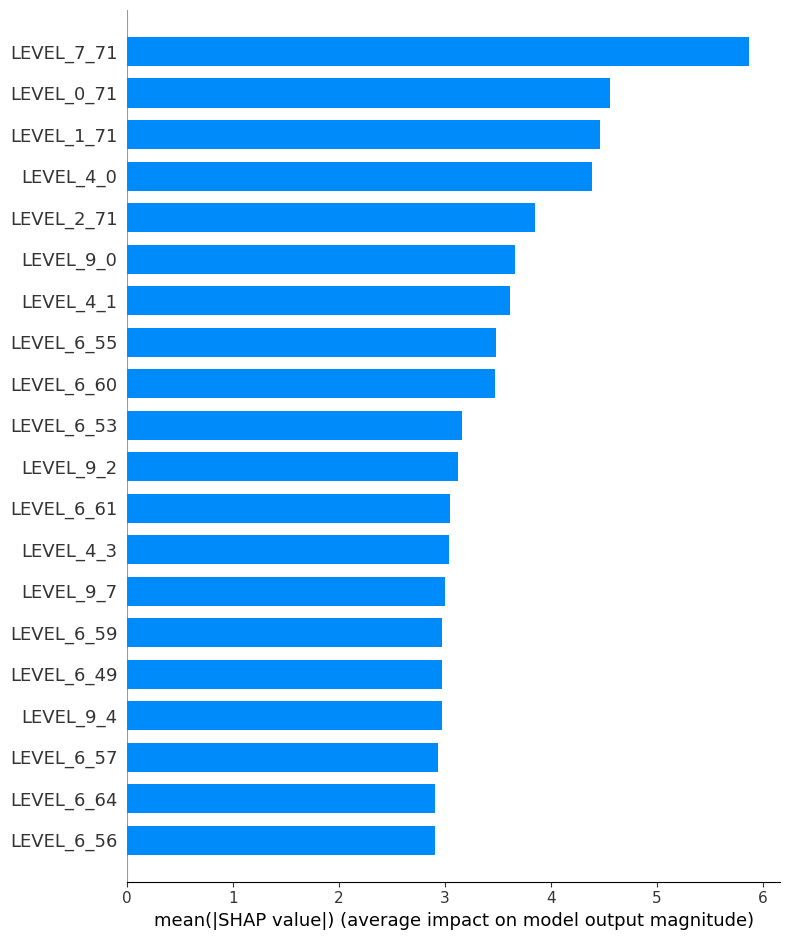

In [17]:
shap.summary_plot(shap_values, features=x_samples_values, feature_names=data.columns[2:], plot_type="bar")

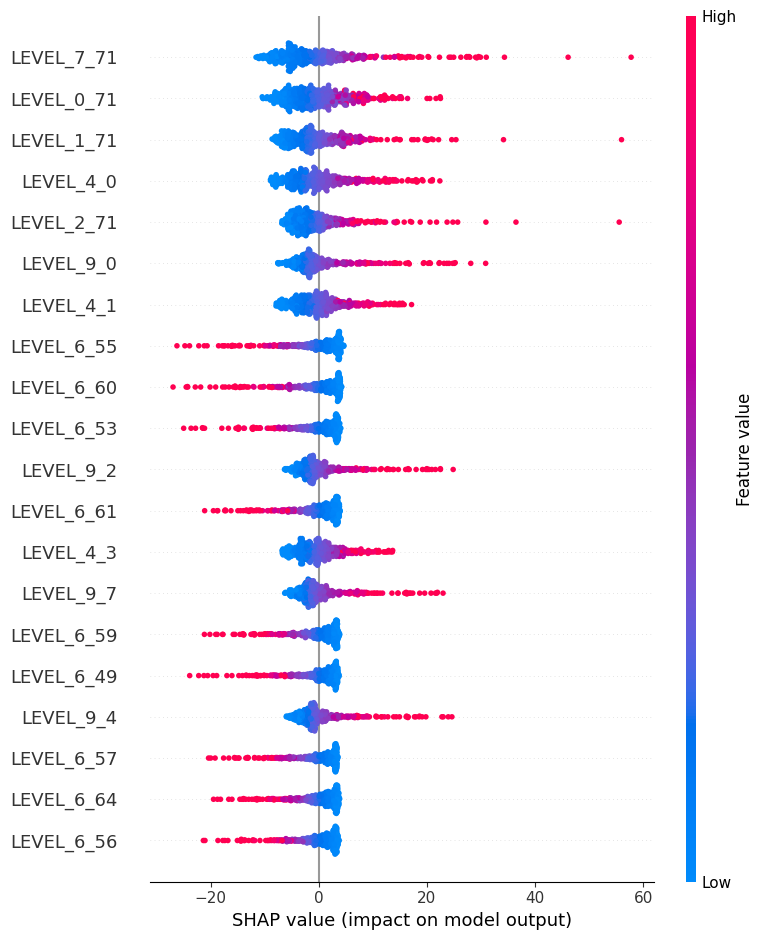

In [18]:
shap.summary_plot(shap_values, features=x_samples_values, feature_names=data.columns[2:], plot_type="dot")

### Model Evaluation

In [51]:
with torch.no_grad():
    y_pred = pd.DataFrame(model(x_test_tensor).cpu().numpy(), columns=["PREDICTION"])
    results = pd.merge(y_test.reset_index(drop=True), y_pred, left_index=True, right_index=True)

In [52]:
results["DIFF"] = (results["TARGET"] - results["PREDICTION"])**2

In [53]:
results

,TARGET,PREDICTION,DIFF
0,120.166667,123.495811,11.083205
1,257.166667,255.843231,1.751481
2,124.500000,127.635887,9.833788
3,112.000000,119.050911,49.715345
4,166.000000,169.753021,14.085168
...,...,...,...
3316,136.166667,137.346558,1.392143
3317,189.666667,188.798309,0.754044
3318,275.166667,279.107391,15.529311
3319,212.000000,213.173065,1.376082


### Model Saving

In [58]:
# Create models directory
directory = f"../models/simple/{target_gauge_id}"
os.makedirs(directory, exist_ok=True)

# Save the scaler
dump(scaler, f"{directory}/{predict_next_hours}.bin", compress=True)

# Save the model
torch.save(model.state_dict(), f"{directory}/{predict_next_hours}.pth")